# Lung Cancer Survival Analysis
In this notebook, we're going to explore an example of how to apply data science and machine learning techniques to clinical research with the goal of conducting survival analysis of lung cancer from the Veterans' Administration Lung Cancer Trial (1980). The survival analysis in this project is built on top of `scikit-learn` and was meant to just be an exploratory analysis for self-learning. 

## Table of Contents
1. [A Brief Introduction to Survival Analysis](#Section_1)
2. [Dataset Description](#Section_2)
3. [Problem Definition](#Section_3)
4. [Exploratory Data Analysis](#Section_4)
5. [Survival Function & Kaplan-Meier Estimate](#Section_5)
6. [Considering Other Variables by Stratification & Log-Rank Test](#Section_6)
7. [Multivariate Survival Models](#Section_7)
8. [Measuring the Performance of Survival Models](#Section_8)
9. [Feature Selection: Which Variable is Most Predictive?](#Section_9)
10. [Resources](#Section_10)

<a id='Section_1'></a>
## 1. A Brief Introduction to Survival Analysis 
This section was written to provide those who lack a strong background in survival analysis (mainly myself) a brief introduction to 1) what is survival analysis and its role in cancer studies, 2) data censoring - an important topic that has big implications for survival models, and 3) a very brief overview of the types of models used in survival analysis.  

### 1.1 What is Survival Analysis? 
Survival analysis is concerned with modeling factors that influence the time until an event of interest occurs. In data science and engineering this is also referred to as reliability analysis where the goal is to establish a connection between covariates/features and the time of an event. 

In cancer research we may look at clinical characteristics of a patient on which his/her/their survival depends (age, gender, time of treatment, etc.). While historically this type of analysis has been used to analyze time to death (i.e. survival) like it will be used in this notebook, it is also used to analyze a range of other clinical events such as start of treatment to response, time of treatment to recurrence or relapse-free survival time, and many others.

### 1.2 Data Censoring
Survival analysis is a type of regression problem (one wants to predict a continuous value), but with a twist. It differs from traditional regression in that parts of the training data can only be partially observed - they are censored. Specifically, only some individuals may experience the event (the study won't follow until everyone passes) and survival times will be unknown for a subset of individuals. 

Examples (not exhaustive) of censoring include:
- A patient has not (yet) experienced the relevant outcome, such as relapse or death, by the close of the study
- A patient drops out during the study period
- A patient experiences a different event that makes further follow-up impossible
- A patient is lost to follow-up

In general, the feature of censoring means that special methods of analysis are needed and standard graphical methods of data exploration and presentation, notably scatter diagrams, cannot be used. 


#### Data Censoring Example

Below we see the participants of a clinical study investigating coronary heart disease and has been carried out over a 1 year period

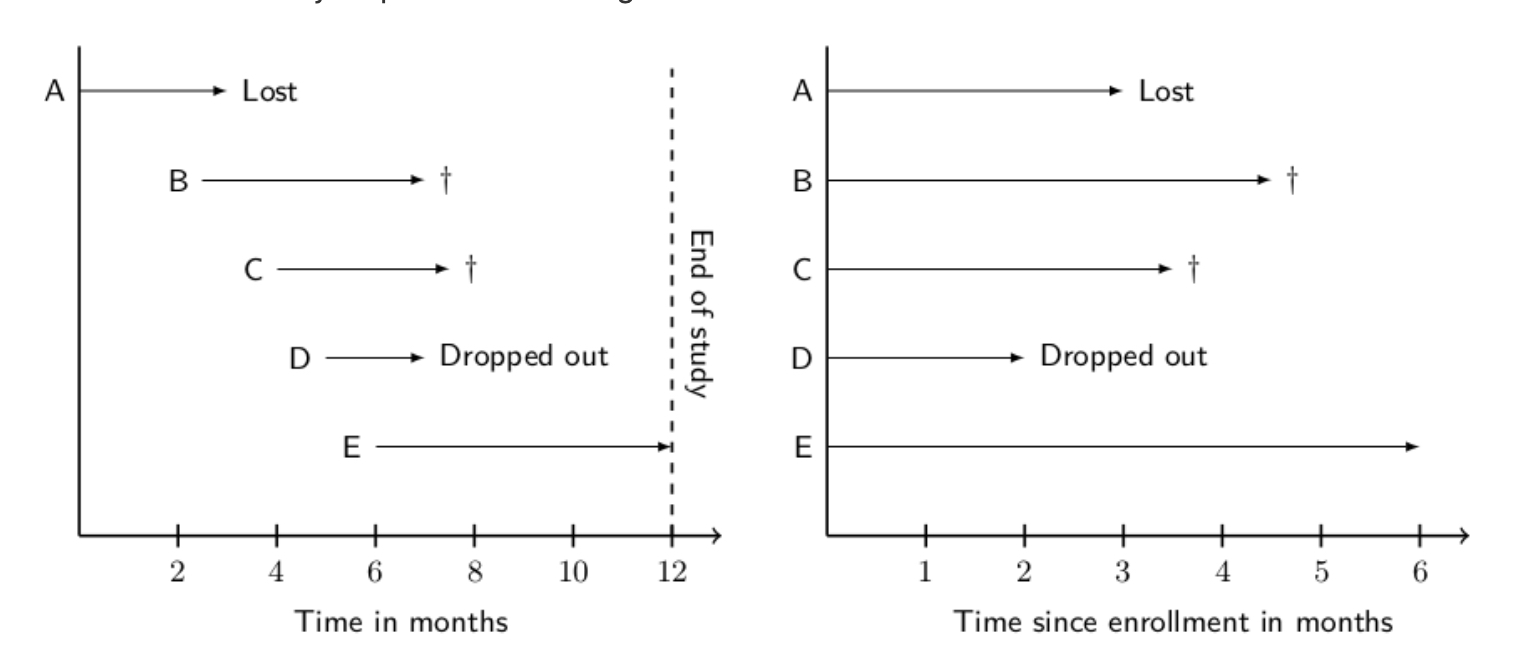

* Patient A was lost to follow-up after 3 months with no recorded cardiovascular event
* Patient B experienced an event 4.5 months after enrollment 
* Patient C experienced an event 3.5 months after enrollment
* Patient D withdrew from the study 2 months after enrollment
* Patient E did not experience any event before the study ended 

Consequently, the exact time of a cardiovascular event can only be calculated for patients B & C; their records are *uncensored*. For the remaining patients it is unknown whether they did or did not experience an event after termination of the study. The only available information for patients A, D, and E is that they were event-free up to their last follow-up. Therefore their records are *censored*.

### 1.3 A (Very) Brief Overview of Models/Methods Used in Survival Analysis

**Kaplan-Meier (KM) estimate and plots (non-parametric)**
> The *Kaplan-Meier method* estimates the survival function, which is the probability of "surviving" (i.e., the probability that the event has not yet occurred) beyond a certain time point. A plot of the Kaplan-Meier estimate is referred to as the Kaplan-Meier curve. The KM curve is a plot of probability (y-axis) against time (x-axis), and it is a step function in which the estimated survival probability changes/drops vertically only at the time of each event. Plotting several KM curves allows for a visual comparison of estimated survival probabilities between 2+ groups, for example treatment or exposure groups. The curves can be statistically compared with log-rank tests (see below).

**Log-rank test (non-parametric)**
>The *log-rank test* is a popular method to test the null hypothesis of no difference in survival between 2 or more independent groups. The test compares the entire survival experience between groups and can be thought of as test of whether each group's survival curves are identical/overlap or differ. Unlike the KM plots, the log-rank test provides a measure of statistical significance. 

> It is important to note that there are several variations of the log-rank test statistic used by various statistical programming software (e.g., R, STATA). However, generally speaking the test is essentially multiple separate independence tests (e.g., Chi Square Test, Fisher's Exact Test) pooled together, what varies between test variations is the type of independence test used. Additionally, while the log-rank test assesses the statistical significance it does not estimate the effect size. Moreover, while there is a way to adjust for a few categorical variables, the log-rank test is essentially not useful to analyze the relationships of multiple variables on the survival time. To estimate the effect size or construct multivariate survival models we will need to use a Cox regression model (below). 

**Cox Regression models (semi-parametric)**
> The *Cox Regression model* is also referred to as the Cox-proportional Hazard model. While the other methods in this list measure survival (time to event), the Cox-proportional Hazard model examines the hazard function, hence its name. This function can be thought of as the instantaneous risk of experiencing the event of interest at a certain time point (i.e., the probability of experiencing the event during an infinitesimally small time period). The event risk is inversely related to the survival function; thus, “survival” rapidly declines when the hazard rate is high and vice versa.

>The regression coefficients in Cox proportional hazards regression can conveniently be interpreted in terms of a hazard ratio (HR) for a 1-unit increase in the independent variable, for continuous independent variables, or versus a reference category, for categorical independent variables. While the HR is not the same as a relative risk, it can for all practical purposes be interpreted as such by researchers who are not familiar with the intricacies of survival analysis techniques.

**Exponential models (parametric) - not typically used**
> In general terms, we tend to go for a parametric model whenever we have normally distributed data. However survival data are rarely normally distributed which is why exponential models are not typically used for this type of analysis.  

<a id='Section_2'></a>
## 2. Dataset Description
The Veterans’ Administration Lung Cancer Trial (retrieved from Kalbfleisch and Prentice 1980) is a randomized trial of two treatment regimens for lung cancer. The [dataset](http://lib.stat.cmu.edu/datasets/veteran) consists of 137 patients and 8 variables which are described below.

- `Treatment`: denotes the type of lung cancer treatment the patient received; `standard` or `test` drug
- `Celltype`: denotes the cell type involved; `squamous`, `small cell`, `adeno`, `large`
- `Karnofsky_score`: is the [Karnofsky score](http://www.npcrc.org/files/news/karnofsky_performance_scale.pdf)
- `Diag`: time since diagnosis in months
- `Age`: age in years
- `Prior_Therapy`: denotes any prior therapy; `none` or `yes`
- `Status`: denotes the status of the patient as dead or alive; `dead` or `alive`
- `Survival_in_days`: survival time in days since treatment 

<a id='Section_3'></a>
## 3. Problem Definition
> Our primary interest is studying whether there are subgroups that differ in survival and whether we can predict survival times

<a id='Section_4'></a>
## 4. Exploratory Data Analysis
Exploratory data analysis is a technique for summarizing, visualizing, and becoming intimately familiar with the important characteristics of a dataset. While this process can be a bit tedious, *one does not simply*, [insert classic LOTR meme] skip the EDA process to jump right into building algorithms/models. EDA helps maximize insights, detect outliers and anomalies, and test unconscious/unintentional assumptions. 

### 4.1 Preparing the Tools

In [1]:
# Install scikit survival module (1x)
# pip install scikit-survival

In [34]:
# Importing tools for regular EDA and plotting libraries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Importing tools for Survival Analysis from Scikit-Learn
from sklearn import set_config
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import concordance_index_censored
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
# Importing STATA to run some of the data analysis visualizations
import stata_setup 
stata_setup.config("/Applications/Stata", "se")
from pystata import stata


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user  perpetual
Serial number: 401706359743
  Licensed to: Lisa Fleming
               

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


### 4.2 Upload Dataset
To be fully compatible with scikit-learn, `Status` and `survival_in_days` needs to be stored as structured arrays with the first field indicating whether the actual survival time was observed or if it was censored. The second field needs to denote the observed survival time, which corresponds to the time of death or the last time the person was contected

In [3]:
# import data for models
from sksurv.datasets import load_veterans_lung_cancer
data_x, data_y = load_veterans_lung_cancer()

# import csv into dataframe for exploratory analysis
df = pd.read_csv("https://r-data.pmagunia.com/system/files/datasets/dataset-25346.csv")
df.head()

,trt,celltype,time,status,karno,diagtime,age,prior
0,1,squamous,72,1,60,7,69,0
1,1,squamous,411,1,70,5,64,10
2,1,squamous,228,1,60,3,38,0
3,1,squamous,126,1,60,9,63,10
4,1,squamous,118,1,70,11,65,10


### 4.3 Preparing Dataset & Exploratory Analysis

In [4]:
# Rename columns
df = df.rename(columns = {'trt':'Treatment', 'celltype':'Celltype', 'time':'Survival_in_days', 'status':'Status', 'karno':'Karnofsky', 'diagtime':'Diag', 'age':'Age', 'prior':'Prior_therapy'})
df.head()

,Treatment,Celltype,Survival_in_days,Status,Karnofsky,Diag,Age,Prior_therapy
0,1,squamous,72,1,60,7,69,0
1,1,squamous,411,1,70,5,64,10
2,1,squamous,228,1,60,3,38,0
3,1,squamous,126,1,60,9,63,10
4,1,squamous,118,1,70,11,65,10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Treatment         137 non-null    int64 
 1   Celltype          137 non-null    object
 2   Survival_in_days  137 non-null    int64 
 3   Status            137 non-null    int64 
 4   Karnofsky         137 non-null    int64 
 5   Diag              137 non-null    int64 
 6   Age               137 non-null    int64 
 7   Prior_therapy     137 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 8.7+ KB


In [7]:
df.isnull().sum()

Treatment           0
Celltype            0
Survival_in_days    0
Status              0
Karnofsky           0
Diag                0
Age                 0
Prior_therapy       0
dtype: int64

***Observation:*** No missing values in this data set (look for reference: https://towardsdatascience.com/how-to-create-a-simple-cancer-survival-prediction-model-with-eda-629dfa45d98b) DELETE LATER

In [8]:
df.describe().round(1)

,Treatment,Survival_in_days,Status,Karnofsky,Diag,Age,Prior_therapy
count,137.0,137.0,137.0,137.0,137.0,137.0,137.0
mean,1.5,121.6,0.9,58.6,8.8,58.3,2.9
std,0.5,157.8,0.2,20.0,10.6,10.5,4.6
min,1.0,1.0,0.0,10.0,1.0,34.0,0.0
25%,1.0,25.0,1.0,40.0,3.0,51.0,0.0
50%,1.0,80.0,1.0,60.0,5.0,62.0,0.0
75%,2.0,144.0,1.0,75.0,11.0,66.0,10.0
max,2.0,999.0,1.0,99.0,87.0,81.0,10.0


In [9]:
#Add a describe/summary using STATA because I like the formatting (easier to read, in my opinion)
stata.pdataframe_to_data(df, force=True)
stata.run('summarize')


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   Treatment |        137     1.49635    .5018215          1          2
    Celltype |          0
Survival_i~s |        137    121.6277    157.8167          1        999
      Status |        137    .9343066    .2486546          0          1
   Karnofsky |        137    58.56934    20.03959         10         99
-------------+---------------------------------------------------------
        Diag |        137    8.773723    10.61214          1         87
         Age |        137    58.30657    10.54163         34         81
Prior_ther~y |        137    2.919708    4.563375          0         10


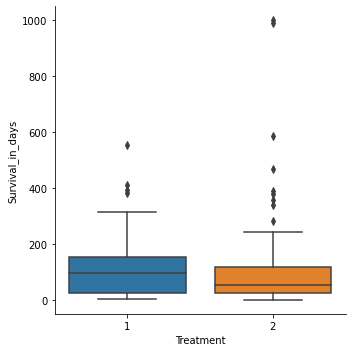

In [10]:
#Visualize Target Variable (Survival_in_days) by Treatment group (1=standard, 2=test)
sns.catplot(kind='box',
            data=df,
            x='Treatment',
            y='Survival_in_days')
plt.show()

***Observation:*** We see on average the survival rate (in days) for patients who receive standard treatment is longer compared to the test treatment.

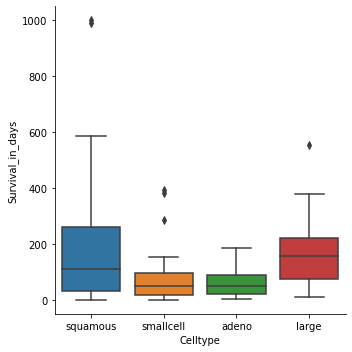

In [11]:
#Visualize Target Variable (Survival_in_days) by Treatment group (1=standard, 2=test)
sns.catplot(kind='box',
            data=df,
            x='Celltype',
            y='Survival_in_days')
plt.show()

***Observation:*** in this cohort of patients those with large cell and squamous cell, on average have a longer survival rate. While, patients with smallcell and adeno, on average have a shorter survival rate. 

In [12]:
df["Celltype"].value_counts(normalize=True, dropna=False).round(2)

smallcell    0.35
squamous     0.26
adeno        0.20
large        0.20
Name: Celltype, dtype: float64

In [13]:
df["Prior_therapy"].value_counts(normalize=True, dropna=False).round(2) #(0 = no, 10 = yes)

0     0.71
10    0.29
Name: Prior_therapy, dtype: float64

In [14]:
df["Treatment"].value_counts(normalize=True, dropna=False).round(3) #(1 = standard, 2 = test)

1    0.504
2    0.496
Name: Treatment, dtype: float64

In [15]:
df["Status"].value_counts(normalize=True, dropna=False).round(2) #(1 = dead, 0 = alive)

1    0.93
0    0.07
Name: Status, dtype: float64

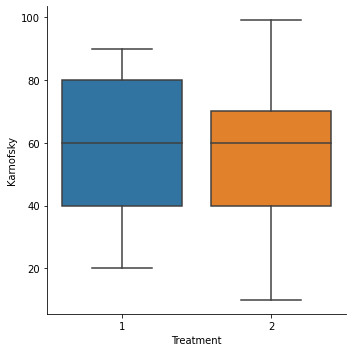

In [18]:
#Visualize Target Variable (Survival_in_days) by Treatment group (1=standard, 2=test)
sns.catplot(kind='box',
            data=df,
            x='Treatment',
            y='Karnofsky')
plt.show()

***Observation:*** The median Karnofsky score is the same for both forms of treatment. WORK ON THIS *****

<a id='Section_5'></a>
## 5. The Survival Function & the Kaplan-Meier Estimator 
A key quantity in survival analysis is the so-called survival function, which relates time to the probability of surviving beyond a given time point. The survival function *S(t)* returns the probability of survival beyond time *'t'* where *T* is the patient's survival time.
> **S(t) = P(T>t)**

To help explain this function a bit more, if we observed the exact survival time of all subjects, i.e. everyone died before the study ended, the survival function at time *t* can simply be estimated by the ratio of patients surviving beyond time *t* and the total number of patients 

<div>
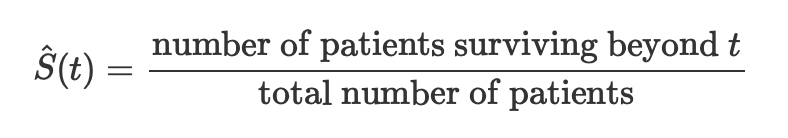
    </div>

### 5.1 The Kaplan-Meier Estimator
In the presence of censoring, this estimator cannot be used, because the numerator is not always defined. If survival times are right-censored, the Kaplan-Meier estimator remains valid. We imported the estimator from the scikit-learn module. 

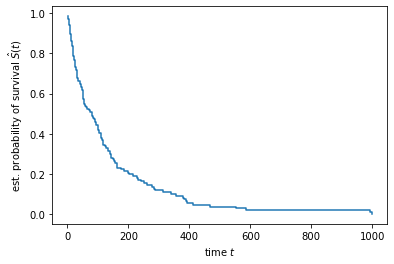

In [5]:
# Kaplan-Meier Curves
# Function uses inputs of status and surival in days to output the time "t" and probabilty of survival "S(t)"
time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$");

***Observation:*** The estimated curve is a step function, with steps occurring at time points where one or more patients died. From the plot we can see that most patients died in the first 200 days, as indicated by the steep slope of the estimated survival function in the first 200 days.

<a id='Section_6'></a>
## 6. Considering Other Variables by Stratification & Log-Rank Test

### 6.1 Survival Functions by Treatment
Patients enrolled in the Veterans' Administration Lung Cancer Trial were randomized to one of two treatments: `standard` and a new `test` drug. Below we can see the distribution of how many patients underwent the standard treatment and how many received the new drug. 

In [7]:
print(data_x["Treatment"].value_counts(normalize=True, dropna=False).round(3))
data_x["Treatment"].value_counts()

standard    0.504
test        0.496
Name: Treatment, dtype: float64


standard    69
test        68
Name: Treatment, dtype: int64

***Observation:*** We see from above, roughly half the patients received the alternative treatment. Below we will estimate the survival function in both treatment groups separately to determine if there is any difference in survival between the two groups.

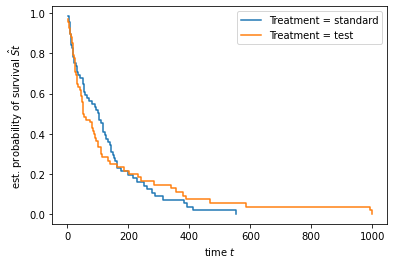

In [5]:
# Apply Kaplan-Meier Estimator to Data for Both Treatment Types (Test & Standard)
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
                label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}{t}$")
plt.xlabel("time $t$")
plt.legend(loc="best");

***Observation:*** Unfortunately the results are inconclusive, because the difference between the two estimated survival functions is too small to confidently argue that the drug affects survival or not.

***Important Note:*** Visually comparing estimated survival curves in order to assess whether there is a difference in survival between groups is usually not recommended, because this method can be highly suggestive. Statistical tests such as the log-rank test are more appropriate.

In [12]:
# Log-Rank Test
group_indicator = data_x.loc[:, "Treatment"]
chisq, pvalue, stats, covar = compare_survival(
                                data_y, 
                                group_indicator, 
                                return_stats=True)
print(stats)

          counts  observed   expected  statistic
group                                           
standard      69        64  64.500197  -0.500197
test          68        64  63.499803   0.500197


In [15]:
print(chisq, pvalue)

0.008227343202350305 0.9277272333400758


***Observations:*** With the log-rank test we can see that the difference in survival curves between treatment types - standard and test - is not statistically significant (the chi-square value is very low and the p-value is high, close to 1.0)

### 6.2 Survival Functions by Cell Type

Below we will look at Kaplan-Meier Curves by cell type (squamous, small cell, adeno, and large cell)

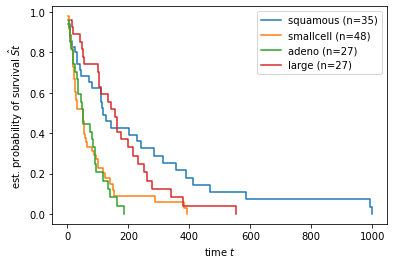

In [9]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                          data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
            label="%s (n=%d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}{t}$")
plt.xlabel("time $t$")
plt.legend(loc="best");

***Observation:*** Here we can observe a difference between patients with squamous or large cell and those with small cell or adeno. Namely, we can see patients in this study with squamous or large cell seem to have a better prognosis compared to patients with small or adeno cells.

In [16]:
# Log-Rank Test
group_indicator = data_x.loc[:, "Celltype"]
chisq, pvalue, stats, covar = compare_survival(
                                data_y, 
                                group_indicator, 
                                return_stats=True)
print(stats)

           counts  observed   expected  statistic
group                                            
adeno          27        26  15.693765  10.306235
large          27        26  34.549478  -8.549478
smallcell      48        45  30.102079  14.897921
squamous       35        31  47.654678 -16.654678


In [18]:
print(chisq, pvalue)

25.40370034578536 1.271245939006091e-05


***Observations:*** With the log-rank test we can see that the difference in survival curves between cell types is statistically significant (the chi-square statistic is high and the p-value is well below 0.05)

<a id='Section_7'></a>
## 7. Multivariate Survival Models & Cox's Proportional Hazards Model

In the Kaplan-Meier approach used above, we estimated multiple survival curves by dividing the dataset into smaller sub-groups according to a variable (first `Treatment` and then `Celltype`). If we want to consider more than 1 or 2 variables, this approach quickly becomes infeasible since subgroups will become very small. Instead, we can use a linear model, ***Cox's Proportional Hazards Model***, to estimate the impact each variable has on survival. 

First however, we need to convert the categorical variables in the dataset into numeric values. We use scikit-learns `OneHotEncoder` module to do this. 

In [22]:
# Split data into training (80%) and test (20%) sets
va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
                                                data_x, data_y, test_size=0.2,
                                                stratify=data_y["Status"],
                                                random_state=0)

In [24]:
#imported above using from sksurv.preprocessing import OneHotEncoder
va_x_train_numeric = OneHotEncoder().fit_transform(va_x_train)
va_x_train_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
66,38.0,1.0,0.0,0.0,80.0,5.0,0.0,0.0
121,62.0,0.0,0.0,0.0,80.0,4.0,1.0,1.0
107,60.0,0.0,0.0,0.0,40.0,2.0,0.0,1.0
57,47.0,1.0,0.0,0.0,70.0,2.0,0.0,0.0
98,72.0,0.0,1.0,0.0,70.0,3.0,0.0,1.0


Survival models in **scikit-survival** follows the same rules as estimators in scikit-learn, specifically they have a **fit** method, which requires a data matrix `data_x_numeric` and a structured array of survival times and binary event indicators `data_y`.

In [25]:
#import from above sklearn.import set_config
#import from above sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text") #displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(va_x_train_numeric, va_y_train)

CoxPHSurvivalAnalysis()

The <span style="color:green">RESULT</span> is a vector of coefficients, one for each variable, where each value corresponds to the ***log hazard ratio***.

In [26]:
pd.Series(estimator.coef_, index=va_x_train_numeric.columns)

Age_in_years            -0.000492
Celltype=large          -0.925577
Celltype=smallcell      -0.319981
Celltype=squamous       -1.511234
Karnofsky_score         -0.034342
Months_from_Diagnosis    0.002009
Prior_therapy=yes       -0.203039
Treatment=test           0.272010
dtype: float64

Another way we can use this **Cox Proportional Hazard Model** is to predict the survival function for a given patient. We do not have data for other patients to test the prediction of survival functions, but purely to show the code and for my own personal practice, we will create four synthetic patients and then pass the appropriate data through the function to generate ***survival functions*** using the `predict_survival_function`.

In [8]:
# Four synthetic patients
x_new = pd.DataFrame.from_dict({
    1: [80, 0, 1, 0, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 1],
    3: [45, 1, 0, 0, 60, 1, 0, 0],
    4: [60, 0, 1, 0, 60, 1, 0, 0]},
        columns=va_x_train_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,80,0,1,0,60,1,0,1
2,65,0,0,1,60,1,0,1
3,45,1,0,0,60,1,0,0
4,60,0,1,0,60,1,0,0


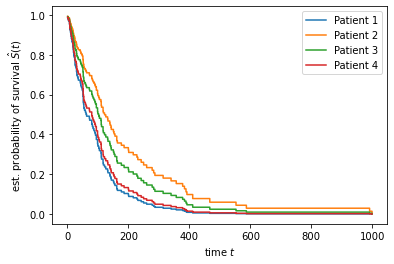

In [9]:
# Survival Functions
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_function in enumerate(pred_surv):
    plt.step(time_points, surv_function(time_points), where="post",
            label = "Patient %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

A more comprehensive method for checking the predictive power of the **Cox Proportional Hazard** model is by using the test data and `predict` function, as we will see in the next section.

<a id='Section_8'></a>
## 8. Measuring the Performance of Survival Models

Once we fit a survival model, we then want to assess how well a model can actually predict survival. Our test data is usually subject to censoring too, therefore metrics like root mean squared error or correlation are unsuitable. Instead, we need to use generalization of the area under the ROC curve (receiver operating characteristic) called **Harrel's concordance index** or **c-index**. 

Interpretation is identical to the traditional area under the ROC curve metric for binary classification:
- a value of 0.5 denotes a random model
- a value of 1.0 denotes a perfect model
- a value of 0.0 denotes a perfectly wrong model

In [30]:
# from sksurv.metrics import concordance_index_censored
prediction = estimator.predict(va_x_train_numeric)
result = concordance_index_censored(va_y_train["Status"], va_y_train["Survival_in_days"], prediction)
result[0]

0.7581311769991015

In [31]:
# Alternative method for printing model's c-index
estimator.score(va_x_train_numeric, va_y_train)

0.7581311769991015

***Observation:*** Our model's c-index indicates that the model performs better than a random model, but it is also far from perfect.

Below we will use the `predict` method and the test dataset to assess how well our model predicts time of death from lung cancer.

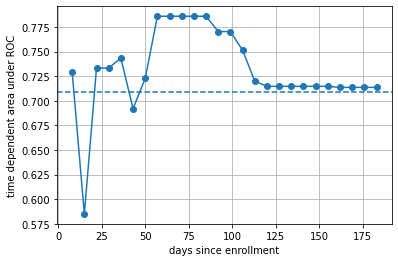

In [36]:
va_x_test_numeric = OneHotEncoder().fit_transform(va_x_test)
va_times = np.arange(8, 184, 7)
cph_risk_scores = estimator.predict(va_x_test_numeric)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days since enrollment")
plt.ylabel("time dependent area under ROC")
plt.grid(True)

***Observations:*** The plot above shows that the model is doing moderately well on average with a c-index score (or area under ROC curve) of ~0.72 (dashed line). However we can see a clear difference in performance between the first and second half of the 6 month time range. During the first 2 months the ability to predict is highly variable and quite poor, but it improves after that. Thus we can conclude that the model is most effective in predicting death in the medium-term, but very poor at predicting death in the short-term. 

<a id='Section_9'></a>
## 9. Feature Selection: Which Variable is Most Predictive?

The model above considered all available variables for prediction. Next we want to investigate which variables are the best predictors of risk of early death from lung cancer. We fit a Cox model to each variable individually and record the c-index on the training set.

In [37]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(va_x_train_numeric.values, va_y_train)
pd.Series(scores, index=va_x_train_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.698562
Celltype=smallcell       0.582120
Celltype=squamous        0.573675
Celltype=large           0.560467
Prior_therapy=yes        0.532704
Treatment=test           0.529470
Age_in_years             0.527134
Months_from_Diagnosis    0.476550
dtype: float64

***Observations:*** Looking at the c-index scores we see the `Karnofsky_score` has the greatest predictive power, whereas we see `Prior_therapy` and `Months_from_Diagnosis` have almost no predictive power on their own (the c-index is essentialy 0.5 which means the model could be interpreted as random). It's important to reduce the number of input variables to only those that are important to reduce the computational cost of the model and, in some cases, to improve the performance of the model. 

In [39]:
# Create a pipeline that puts all the parts together

#from sklearn.feature_selection import SelectKBest
# from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                ('select', SelectKBest(fit_and_score_features, k=3)),
                ('model', CoxPHSurvivalAnalysis())])

We will use `GridSearchCV` to help us determine how many variables we need to include in the model. GridSearchCV allows us to run the model through a number of different iterations and compare metrics for each iteration. For this model, we will define the range of parameters, **'k'** of the `SelectKBest` class, and allow **'k'** to vary from 1 feature/variable to all 8 features.

In [40]:
# Define a range of parameters to explore during grid search
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, va_x_train_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(va_x_train, va_y_train)

results=pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,3,{'select__k': 3},0.730769,0.723661,0.694309,0.716247,0.015781,1,0.711816,0.757528,0.758436,0.742593,0.021766
4,5,{'select__k': 5},0.758013,0.688256,0.695935,0.714068,0.031232,2,0.739193,0.758914,0.779012,0.759040,0.016256
5,6,{'select__k': 6},0.756410,0.671848,0.705691,0.711316,0.034751,3,0.743928,0.759311,0.780247,0.761162,0.014885
7,8,{'select__k': 8},0.740385,0.663212,0.710569,0.704722,0.031776,4,0.746809,0.761490,0.781481,0.763260,0.014210
6,7,{'select__k': 7},0.735577,0.670121,0.708130,0.704609,0.026838,5,0.744751,0.758518,0.781070,0.761446,0.014971
3,4,{'select__k': 4},0.724359,0.708117,0.670732,0.701069,0.022453,6,0.708522,0.758320,0.768519,0.745120,0.026212
0,1,{'select__k': 1},0.698718,0.630397,0.739024,0.689380,0.044836,7,0.694319,0.714739,0.680041,0.696366,0.014239
1,2,{'select__k': 2},0.724359,0.662349,0.679675,0.688794,0.026124,8,0.702141,0.740887,0.730041,0.724356,0.016321


***Observations:*** From the table above we can see that according to the rank_test_score, if we include the 2 most predictive features/variables it gets the highest score. We can also retrieve and use the most optimal iteration of the model `GridSearchCV` found by using the `best_params_`.

In [41]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.067277
Celltype=smallcell    0.271007
Karnofsky_score      -0.031285
dtype: float64

<a id='Section_10'></a>
## 10. Resources

I wanted to include references so I can refer back to them in the future if I need.
- https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/12-survival-analysis
- https://journals.lww.com/anesthesia-analgesia/Fulltext/2021/04000/Kaplan_Meier_Curves,_Log_Rank_Tests,_and_Cox.7.aspx
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3059453/
- https://scikit-survival.readthedocs.io/en/stable/api/index.html